## **Import the needed packages**

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KDTree
from sklearn.preprocessing import Normalizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Roy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Roy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Load the dataset**

In [51]:
#-- The BBC dataset
df = pd.read_csv('articles.csv')

#-- let's look at some of the data
print("Number of rows : " + str(df.shape[0]))
df.sample(5)

Number of rows : 2225


,text,Label
614,Holmes wins '2004 top TV moment'\n\nSprinter K...,Entertainment
1446,Hodges announces rugby retirement\n\nScarlets ...,Sports
289,"India calls for fair trade rules\n\nIndia, whi...",Business
1984,Multi-purpose TV aids India\n\nTwo-thirds of t...,Technology
1299,Goldsmith denies war advice claim\n\nThe attor...,Politics


## **Let's keep the data we want**

In [52]:
abstract_df = pd.DataFrame(columns=['text', 'word_count'])
abstract_df['text'] = df['text']
abstract_df.reset_index(inplace = True)
abstract_df['word_count'] = abstract_df['text'].apply(lambda x: len(x.split(" ")))
#total_wordcount = abstract_df['word_count'].sum()
#print("sum \t" + str(total_wordcount))
#print(abstract_df.word_count.describe())
abstract_df.head()

,index,text,word_count
0,0,UK economy facing 'major risks'\n\nThe UK manu...,319
1,1,Aids and climate top Davos agenda\n\nClimate c...,442
2,2,Asian quake hits European shares\n\nShares in ...,539
3,3,India power shares jump on debut\n\nShares in ...,171
4,4,Lacroix label bought by US firm\n\nLuxury good...,148


## **Clean our dataset**
To clean our data, we need to do the following:
* remove punctuation and special symbols
* remove tags
* remove digits
* make all characters lower case
* remove all stopwords
* get the lemmas for our words (lemmatization)

In [53]:
corpus = []

#-- initialize the lemmatizer
lem = WordNetLemmatizer()

#-- create a set of stopwords
stop_words = set(stopwords.words("english"))

for text in abstract_df['text']:
    #-- remove all punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    #-- empty tags 
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    #-- remove special characters and digits
    text = re.sub("(\\d|\\W)+"," ", text)
    #-- make all chars lowercase
    text.lower()
    #-- create a list of words 
    words = text.split()
    text = " ".join([lem.lemmatize(word) for word in words if \
                    word not in stop_words])
    corpus.append(text)
    
#-- We've now generated a normalized corpus with only word lemmas
corpus[:1]

['UK economy facing major risk The UK manufacturing sector continue face serious challenge next two year British Chamber Commerce BCC said The group quarterly survey company found export picked last three month best level eight year The rise came despite exchange rate cited major concern However BCC found whole UK economy still faced major risk warned growth set slow It recently forecast economic growth slow little Manufacturers domestic sale growth fell back slightly quarter survey firm found Employment manufacturing also fell job expectation lowest level year Despite positive news export sector worrying sign manufacturing BCC said These result reinforce concern sector persistent inability sustain recovery The outlook service sector uncertain despite increase export order quarter BCC noted The BCC found confidence increased quarter across manufacturing service sector although overall failed reach level start The reduced threat interest rate increase contributed improved confidence sai

## **Create document term matrix using TD-IDF**

In [54]:
#-- function to create document term matrix
def createDTM(text):
    vect = TfidfVectorizer()
    dtm = vect.fit_transform(text)
    #-- create pandas dataframe of DTM
    return pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

#-- let's take a look at the dtm
X = createDTM(corpus)
X[:5]

,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.049918,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## **Query for neighbors within a given radius**

In [55]:
# Instantiate KDTree
tree = KDTree(X, leaf_size=5)

# Query the tree for neighbors within a radius 0.5
print(tree.query_radius(X[:1], r=0.5, count_only=True))

# Indices of neighbors within distance 0.5
ind = tree.query_radius(X[:1], r=0.5)
print(ind)

[1]
[array([0], dtype=int64)]


# **Clustering using k-means algorithm**

In [56]:
vec = TfidfVectorizer(max_df=0.5, min_df=2, use_idf=True)
vec.fit(corpus)
features = vec.transform(corpus)

In [57]:
# Instantiate KMeans
cls = MiniBatchKMeans(n_clusters=5, random_state=42)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [58]:
# Predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset)
cls.labels_

array([3, 4, 3, ..., 2, 0, 2])

In [59]:
# Reduce the features to 2D
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(features.toarray())

# Reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

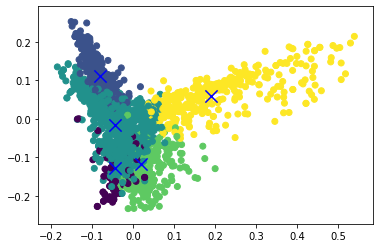

In [60]:
# Making the scatter plot
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b');

# **Homogeneity and Silhouette score**

In [61]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df.Label, cls.predict(features))

0.6447199334522007

In [62]:
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.011338357250552645